In [1]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

In [2]:
model_path = "yolo-models/yolo11x_bia-4.pt"
model = YOLO(model_path)


In [6]:
image_path = Path("images/bo du lieu bia so 4/bia4 (12).bmp")
img = cv2.imread(str(image_path))
if img is None:
    raise FileNotFoundError(f"Image not found at {image_path}")
# Convert BGR to RGB for display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
results = model(img_rgb)


0: 480x640 1 bia, 702.0ms
Speed: 5.5ms preprocess, 702.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


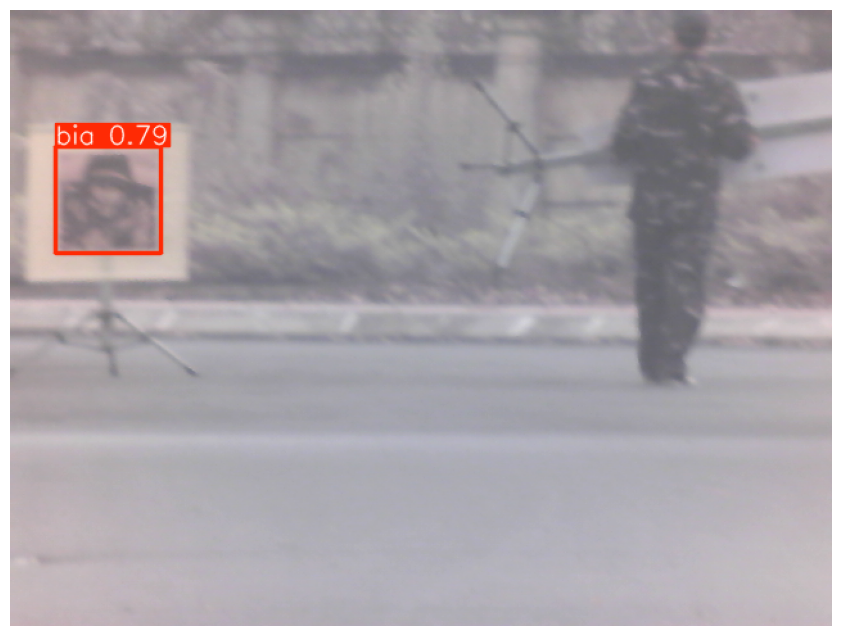

In [8]:
result_img = results[0].plot()  # plot() returns an image with boxes drawn
plt.figure(figsize=(12,8))
plt.imshow(result_img)
plt.axis('off')
plt.show()